In [1]:
!pip install git+https://github.com/VincentStimper/normalizing-flows.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/VincentStimper/normalizing-flows.git to /tmp/pip-req-build-b0pkxbre
  Running command git clone -q https://github.com/VincentStimper/normalizing-flows.git /tmp/pip-req-build-b0pkxbre
  Cloning https://github.com/VincentStimper/residual-flows.git to /tmp/pip-install-pkkzw2vj/residual-flows_7b60c1b5f2d14517bcf950548cfe0dd9
  Running command git clone -q https://github.com/VincentStimper/residual-flows.git /tmp/pip-install-pkkzw2vj/residual-flows_7b60c1b5f2d14517bcf950548cfe0dd9
  Created wheel for normflow: filename=normflow-1.2-py2.py3-none-any.whl size=60862 sha256=cd4ec5ef63c3394295c6d9abd27c93760ca000a3996f80601183c639e4706f47
  Stored in directory: /tmp/pip-ephem-wheel-cache-q3ntokud/wheels/d9/40/c8/9ac98610e01d078086ad1abd95cd552ce5eef5bec50c647dd5
  Created wheel for residual-flows: filename=residual_flows-1.0-py2.py3-none-any.whl size=36203 sha256=fdaac7

In [2]:
# Import basic libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Import Normflow
import normflow as nf

# For plotting
import matplotlib.pyplot as plt
from tqdm import tqdm

# For saving and loading
import pickle
%matplotlib inline

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

# Normalizing Flow demo

In [ ]:
K = 10
beta = 1.0
#torch.manual_seed(0)

flows = []
for i in range(K):
    flows += [nf.flows.Planar((2,))]
target = nf.distributions.TwoModes(2, 0.1)

q0 = nf.distributions.DiagGaussian(2)
nfm = nf.NormalizingFlow(q0=q0, flows=flows, p=target)
nfm.to(device)

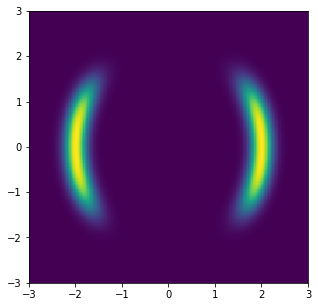

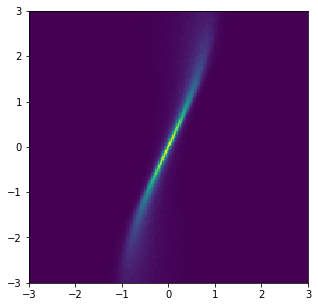

In [ ]:
# Plot target distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
z = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
log_prob = target.log_prob(z.to(device)).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)

plt.figure(figsize=(5, 5))
plt.pcolormesh(xx, yy, prob)
plt.show()

# Plot initial posterior distribution
z, _ = nfm.sample(num_samples=2 ** 20)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(5, 5))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
plt.show()

In [ ]:
class nfmodel(nn.Module):
    def __init__(self, q0=nf.distributions.DiagGaussian(2), flows=flows, p=target):
        super().__init__()

        self.q0 = q0
        self.flows = nn.ModuleList(flows)
        self.p = p

    def sample(self, num_samples=1):
        z, log_q = self.q0(num_samples)
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        return z, log_q


    def reverse_kld(self, num_samples=1, beta = beta):
        z, log_q = self.q0(num_samples)
        #print(z)
        #print(log_q)
        for flow in self.flows:
            #print(flow(z))
            z, log_det = flow(z)
            log_q -= log_det

        log_p = self.p.log_prob(z)
        return torch.mean(log_q) - beta * torch.mean(log_p)


model = nfmodel(q0=nf.distributions.DiagGaussian(2), flows=flows, p=target).to(device)

 40%|███▉      | 1981/5000 [00:07<00:11, 266.66it/s]

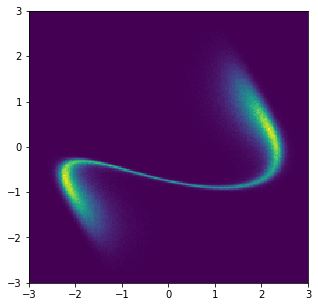

 80%|███████▉  | 3985/5000 [00:15<00:03, 260.74it/s]

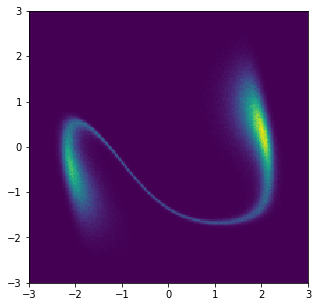

100%|██████████| 5000/5000 [00:19<00:00, 251.18it/s]


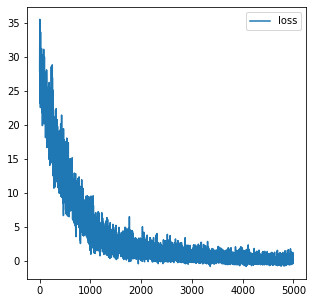

In [ ]:
# Train model
max_iter = 5000
num_samples = 2 * 20
anneal_iter = 10000
annealing = False
show_iter = 2000


loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    if annealing:
        loss = model.reverse_kld(num_samples, beta=np.min([1., 0.01 + it / anneal_iter]))
    else:
        loss = model.reverse_kld(num_samples)
    loss.backward()
    optimizer.step()
    
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

    # Plot learned posterior
    if ((it + 1) % show_iter == 0):
        torch.cuda.manual_seed(0)
        z, _ = model.sample(num_samples=2 ** 20)
        z_np = z.to('cpu').data.numpy()

        plt.figure(figsize=(5, 5))
        plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
        plt.show()

plt.figure(figsize=(5, 5))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

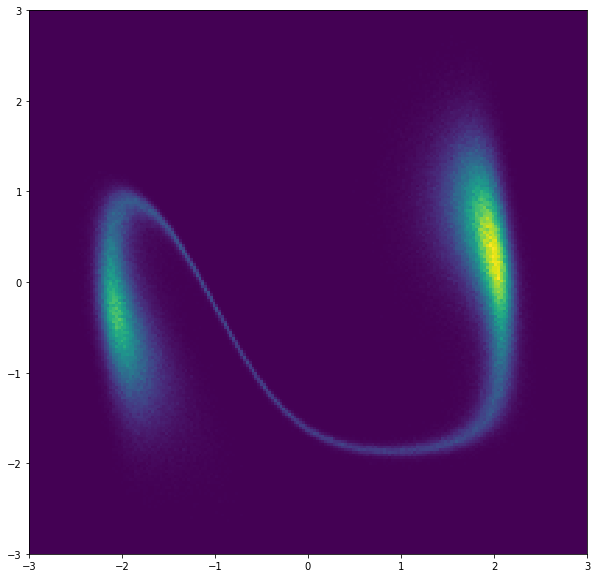

In [ ]:
# Plot learned posterior distribution
z, _ = model.sample(num_samples=2 ** 20)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(10, 10))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (grid_size, grid_size), range=[[-3, 3], [-3, 3]])
plt.show()

# Utility functions regarding Cryo-EM

In [ ]:
# Install Openmm (takes approx 5-7 minutes to run... no need for this if not using potential)
import sys
print(sys.version)
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
!bash Miniconda3-py*.sh -bfp /usr/local
!conda config --set always_yes yes
!conda config --add channels conda-forge
!conda create -n openmm python=3.7 cudatoolkit=10.0 git jupyterlab matplotlib ipympl rdkit openbabel openmm mdtraj pymbar pdbfixer parmed openff-toolkit openmoltools openmmforcefields
sys.path.append('/usr/local/envs/openmm/lib/python3.7/site-packages')
import openmm.testInstallation
openmm.testInstallation.main()

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
--2022-06-08 05:20:04--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89026327 (85M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.10.3-Linux-x86_64.sh’

Miniconda3-py37_4.1 100%[===================>]  84.90M  6.32MB/s    in 14s     

2022-06-08 05:20:19 (5.87 MB/s) - ‘Miniconda3-py37_4.10.3-Linux-x86_64.sh’ saved [89026327/89026327]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - _openmp_mutex==4.5=1_gnu
    - brotlipy==0.7.0=py37h27cfd23_1003
    - ca-certificates==2021.7.5=h06a4308_1
    - certifi==2021.5.30=py37h06a

In [ ]:
from openmm import *
from openmm.app import *
from openmm.unit import *

In [36]:
# Frequently used definitions
dtype = torch.FloatTensor
#enable_cuda = False
#device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

pdbfile = 'water.pdb' #'alanine-dipeptide.pdb'
num_atoms = 3 #22
forcefile = 'amber14/tip3pfb.xml' #'amber14-all.xml'

pklfile = 'water_img1024_dim25_nse1_blob0.001_q0.2.pkl' #'aldip_img1024_dim51_nse1_scl0.001_q1.pkl'
num_imgs = 64 #1024
n_cells = 25 #51
noise_var = 1
blob_var = 0.001
Q = 0.2

num_flows = 5
beta = 10.0
num_epochs = 1000

kB = 1.3807e-26
Avo = 6.0221408e+23
T = 300
kBxAvoxT = kB*Avo*T
print(kBxAvoxT)

2.4944309407680003


In [4]:
# Utility functions for putting gaussian blobs and Cryo-EM image plotting

def create_posmatrix(Q=Q, n_cells=n_cells):
    # Grids of x and y points
    x = torch.linspace(-Q, Q, n_cells, device=device)
    y = torch.linspace(-Q, Q, n_cells, device=device)
    # Create a 2-D meshgrid of (x, y) coordinates.
    x, y = torch.meshgrid(x, y, indexing='xy')

    # Creating mixture of gaussians
    pos = torch.empty(x.shape + (2,), device=device).double()
    pos[:, :, 0] = x
    pos[:, :, 1] = y

    return pos

pos = create_posmatrix()

def torch_createblobs(coords, Q=Q, n_cells=n_cells, blob_var=blob_var, noise_var=0, rot_mat=torch.eye(3), pos=pos):
    new_coords = coords @ rot_mat.T
    noise_matrix = 0 if noise_var == 0 else np.sqrt(noise_var)*torch.randn((n_cells, n_cells))
    normals = torch.zeros((n_cells, n_cells), device=device)

    for row in new_coords:
        normals += torch.exp(-(torch.norm(pos - row[0:2], dim=2)**2)/(2*(blob_var)))

    return normals/(2*np.pi*blob_var*len(new_coords)) + noise_matrix


def plot_cryoem_imgs(img_list, skip_by=1, Q=Q):
    for idx, img in enumerate(img_list):
        if idx % skip_by == 0:
            c = plt.imshow(img.cpu(), cmap ='gray', vmin = 0, vmax = np.abs(img.cpu()).max(),\
                            extent = [-Q, Q, -Q, Q], interpolation = 'nearest', origin = 'lower')
            plt.colorbar(c)

            plt.title(f'Cryo-EM Image {idx+1}', fontweight = "bold")
            plt.show()

print(device)

cpu


In [5]:
class pot_energy(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        reshaped_input = input.reshape(num_atoms, 3)
        ctx.save_for_backward(reshaped_input)

        simulation.context.setPositions(reshaped_input.cpu().numpy())
        state = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)
        return torch.tensor(state.getPotentialEnergy()._value).to(device)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        reshaped_input, = ctx.saved_tensors

        simulation.context.setPositions(reshaped_input.cpu().numpy())
        state = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)
        return -grad_output * torch.tensor(state.getForces(asNumpy=True)._value).reshape(-1, num_atoms*3).to(device)


def potential(vec):
    eq_length, k_length = 0.101181082494, 462750.4
    eq_angle, k_angle = 1.88754640288, 836.8
    #print(vec)

    bond1 = vec[0:3] - vec[3:6]
    bond2 = vec[0:3] - vec[6:9]

    bond_pot = k_length*((eq_length - torch.norm(bond1))**2 + (eq_length - torch.norm(bond2))**2)
    angle_pot = k_angle*(eq_angle - torch.acos(torch.dot(bond1, bond2)/(torch.norm(bond1)*torch.norm(bond2))))**2

    return angle_pot + bond_pot

atm_crd = np.array([[-0.01907088,-0.03568486,0.02280679], [0.03153054,0.04458783,0.05792664], [0.01212991,-0.05448926,-0.07158886]])
print(potential(torch.tensor(atm_crd.flatten())))

tensor(0.0288, dtype=torch.float64)


# Water Molecule Images

In [ ]:
topology = Topology()
chain = topology.addChain()
residue = topology.addResidue("water", chain)
element_O = Element.getByAtomicNumber(8)
element_H = Element.getByAtomicNumber(1)
atom0 = topology.addAtom("O", element_O, residue)
atom1 = topology.addAtom("H", element_H, residue)
atom2 = topology.addAtom("H", element_H, residue)
topology.addBond(atom0, atom1)
topology.addBond(atom0, atom2)

#pdb = PDBFile(pdbfile)
forcefield = ForceField(forcefile)
system = forcefield.createSystem(topology, nonbondedCutoff=1*nanometer, constraints=HBonds)
integrator = LangevinIntegrator(T*kelvin, 1/picosecond, 1*femtoseconds)
simulation = Simulation(topology, system, integrator)
simulation.context.setPositions(np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.5],
    [0.0, 0.1, 0.0],
]) * nanometers)
simulation.context.setPositions(np.array([
    [-0.0130, -0.0369,  0.0223],
    [ 0.0147,  0.0002, -0.0524],
    [-0.0715,  0.0083,  0.0557],
]) * nanometers)

simulation.minimizeEnergy()
#simulation.reporters.append(PDBReporter('output.pdb', 1000))
#simulation.reporters.append(StateDataReporter(stdout, 1000, step=True, volume=True, density=True,
#        potentialEnergy=True, temperature=True))

for i in range(1):
    simulation.step(1000)
    state0 = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)

    print("Potential energy")
    print(state0.getPotentialEnergy())

    print("Atomic positions")
    atm_crd = state0.getPositions(asNumpy=True)._value
    print(atm_crd)
    print(np.linalg.norm(atm_crd[0] - atm_crd[1]))
    print(np.linalg.norm(atm_crd[0] - atm_crd[2]))
    print(np.linalg.norm(atm_crd[1] - atm_crd[2]))

    print("Volume")
    print(state0.getPeriodicBoxVolume())

    print("Forces")
    print(state0.getForces(asNumpy=True))

Potential energy
0.014402640983462334 kJ/mol
Atomic positions
[[-0.01907088 -0.03568486  0.02280679]
 [ 0.03153054  0.04458783  0.05792664]
 [ 0.01212991 -0.05448926 -0.07158886]]
0.10118108691950643
0.10118119670032122
0.16421607541582983
Volume
8.0 nm**3
Forces
[[-54.47779083 -40.93602371  39.47584534]
 [ 23.88903618   3.36059809 -42.10107422]
 [ 30.58875275  37.57542419   2.62522864]] kJ/(nm mol)


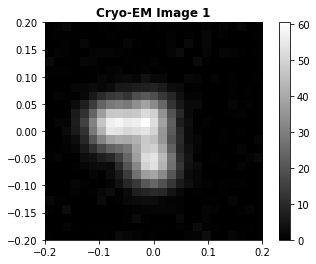

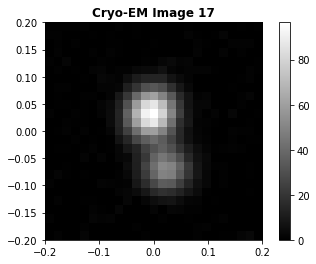

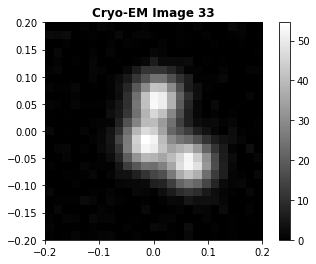

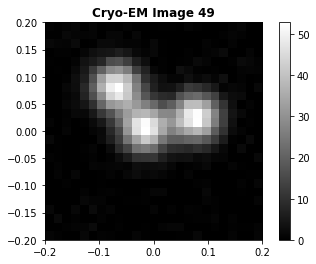

In [6]:
with open(pklfile, 'rb') as inp:
    rot_mats = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]
    pot_energies = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]
    forces_list = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]
    pos_list = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]
    img_list = [i.to(device) for i in pickle.load(inp)[0:num_imgs]]

plot_cryoem_imgs(img_list, skip_by=16)

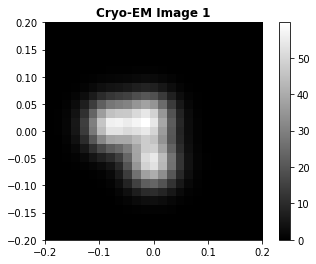

tensor(601.6715)
tensor([[-0.0103,  0.0218,  0.0047],
        [-0.0828,  0.0113, -0.0651],
        [-0.0038, -0.0601,  0.0637]])


In [7]:
idx = 0
img = torch_createblobs(pos_list[idx], rot_mat=rot_mats[idx])

plot_cryoem_imgs([img], skip_by=1)
print(torch.norm(img - img_list[idx])**2)
print(pos_list[idx] @ rot_mats[idx].T)

# Single Image

In [45]:
flows = []
for i in range(num_flows):
    flows += [nf.flows.Planar((num_atoms*3,))]

In [46]:
class nfmodel(nn.Module):
    def __init__(self, flows=flows):
        super().__init__()

        self.q0 = nf.distributions.DiagGaussian(num_atoms*3)
        self.flows = nn.ModuleList(flows)

    def sample(self, num_samples=1):
        z, log_q = self.q0(num_samples)
        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        return z, log_q


    def reverse_kld(self, num_samples=1, target=img_list[idx], rot_mat=rot_mats[idx], target_idx=0, beta=beta):
        z, _ = self.q0(num_samples)
        log_q = 0

        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det

        log_imerr, log_pot = 0, 0
        for molecule in z:
            log_imerr -= torch.norm(target - torch_createblobs(molecule.reshape(3,3)/100, rot_mat = rot_mat))**2
            log_pot -= potential(molecule.flatten()/100)   #pot_energy.apply/kBxAvoxT

        return torch.mean(log_q) - (log_imerr/(2*noise_var) + beta*log_pot)/num_samples


model = nfmodel(flows=flows).to(device)

  0%|          | 2/1000 [00:00<03:01,  5.49it/s]

118568.09


 10%|█         | 102/1000 [00:18<02:41,  5.57it/s]

29370.562


 20%|██        | 202/1000 [00:37<02:25,  5.47it/s]

21672.176


 30%|███       | 302/1000 [00:55<02:07,  5.47it/s]

10197.215


 40%|████      | 402/1000 [01:13<01:47,  5.54it/s]

5322.663


 50%|█████     | 502/1000 [01:31<01:29,  5.54it/s]

4086.612


 60%|██████    | 602/1000 [01:49<01:11,  5.59it/s]

3755.6504


 70%|███████   | 702/1000 [02:07<00:53,  5.53it/s]

2944.0881


 80%|████████  | 802/1000 [02:25<00:36,  5.47it/s]

2414.064


 90%|█████████ | 902/1000 [02:43<00:17,  5.47it/s]

2384.703


100%|██████████| 1000/1000 [03:01<00:00,  5.52it/s]


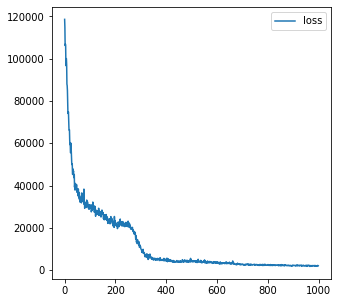

In [47]:
# Train model
max_iter = 1000
num_samples = 100
anneal_iter = 10000
annealing = False

loss_hist = []

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    if annealing:
        loss = model.reverse_kld(num_samples, beta=np.min([1., 0.01 + it / anneal_iter]))
    else:
        loss = model.reverse_kld(num_samples)
    loss.backward()
    optimizer.step()
        
    loss_hist.append(loss.to('cpu').data.numpy())
    if it % (max_iter/10) == 0:
        print(loss_hist[-1])

plt.figure(figsize=(5, 5))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

tensor(0.1004, grad_fn=<CopyBackwards>)
tensor(0.1013, grad_fn=<CopyBackwards>)
tensor(0.1583, grad_fn=<CopyBackwards>)
tensor(39.3042)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


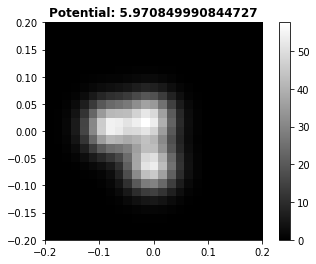

tensor(0.1009, grad_fn=<CopyBackwards>)
tensor(0.1104, grad_fn=<CopyBackwards>)
tensor(0.1779, grad_fn=<CopyBackwards>)
tensor(66.6448)


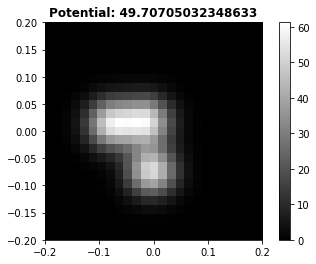

tensor(0.1083, grad_fn=<CopyBackwards>)
tensor(0.0937, grad_fn=<CopyBackwards>)
tensor(0.1665, grad_fn=<CopyBackwards>)
tensor(45.1472)


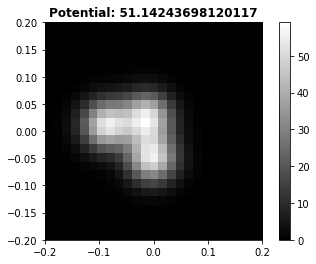

tensor(0.0977, grad_fn=<CopyBackwards>)
tensor(0.0958, grad_fn=<CopyBackwards>)
tensor(0.1662, grad_fn=<CopyBackwards>)
tensor(55.3514)


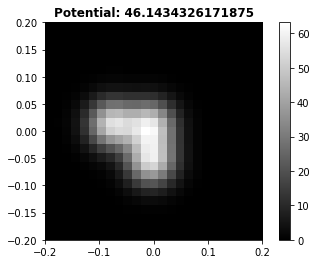

tensor(0.1003, grad_fn=<CopyBackwards>)
tensor(0.0912, grad_fn=<CopyBackwards>)
tensor(0.1619, grad_fn=<CopyBackwards>)
tensor(44.7155)


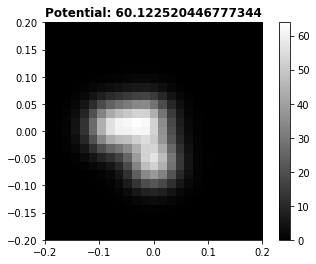

tensor(0.1040, grad_fn=<CopyBackwards>)
tensor(0.1027, grad_fn=<CopyBackwards>)
tensor(0.1665, grad_fn=<CopyBackwards>)
tensor(37.8555)


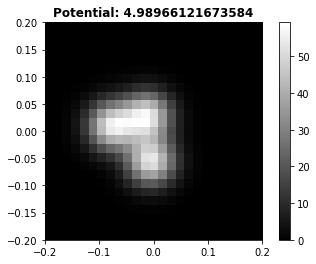

tensor(0.0954, grad_fn=<CopyBackwards>)
tensor(0.0997, grad_fn=<CopyBackwards>)
tensor(0.1439, grad_fn=<CopyBackwards>)
tensor(72.7867)


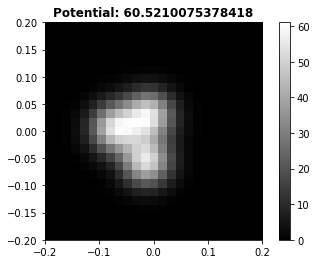

tensor(0.1168, grad_fn=<CopyBackwards>)
tensor(0.1014, grad_fn=<CopyBackwards>)
tensor(0.1803, grad_fn=<CopyBackwards>)
tensor(64.3283)


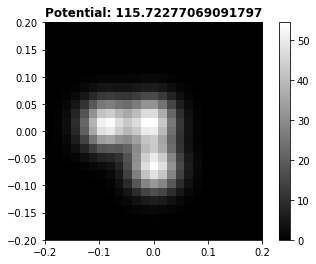

tensor(0.1104, grad_fn=<CopyBackwards>)
tensor(0.0992, grad_fn=<CopyBackwards>)
tensor(0.1668, grad_fn=<CopyBackwards>)
tensor(59.6386)


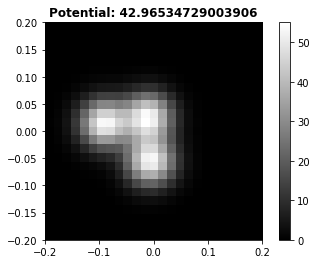

tensor(0.1094, grad_fn=<CopyBackwards>)
tensor(0.0994, grad_fn=<CopyBackwards>)
tensor(0.1659, grad_fn=<CopyBackwards>)
tensor(38.3256)


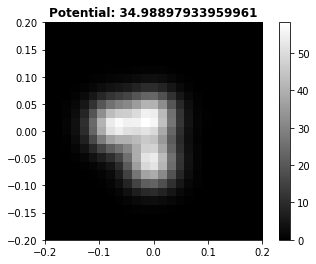

In [48]:
molecules, _ = model.sample(num_samples=10)

for molecule in molecules:
    atm_crd = molecule.reshape(3,3)/100
    print(torch.norm(atm_crd[0] - atm_crd[1]))
    print(torch.norm(atm_crd[0] - atm_crd[2]))
    print(torch.norm(atm_crd[1] - atm_crd[2]))

    img = torch_createblobs(molecule.reshape(3,3)/100, rot_mat=rot_mats[idx]).data
    c = plt.imshow(img.cpu(), cmap ='gray', vmin = 0, vmax = np.abs(img.cpu()).max(),\
                            extent = [-Q,Q,-Q,Q], interpolation = 'nearest', origin = 'lower')
    plt.colorbar(c)

    print(torch.norm(torch.tensor(img) - img_list[idx]))
    plt.title(f'Potential: {potential(molecule.flatten()/100)}', fontweight = "bold")
    plt.show()

In [29]:
"""
atm_crd = molecule.reshape(3,3)/100
print(atm_crd)
print(torch.norm(atm_crd[0] - atm_crd[1]))
print(torch.norm(atm_crd[0] - atm_crd[2]))
print(torch.norm(atm_crd[1] - atm_crd[2]))

simulation.context.setPositions(molecule.reshape(3,3).data.cpu().numpy()/100)
state = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)
print(state.getPotentialEnergy()._value)
print(state.getForces(asNumpy=True))

atm_crd = pos_list[38]

print(atm_crd)
print(torch.norm(atm_crd[0] - atm_crd[1]))
print(torch.norm(atm_crd[0] - atm_crd[2]))
print(torch.norm(atm_crd[1] - atm_crd[2]))

simulation.context.setPositions(pos_list[16].data.cpu().numpy()/100)
state = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)
print(state.getPotentialEnergy()._value)"""

atm_crd = pos_list[idx]
print(torch.norm(atm_crd[0] - atm_crd[1]))
print(torch.norm(atm_crd[0] - atm_crd[2]))
print(torch.norm(atm_crd[1] - atm_crd[2]))

tensor(0.1012)
tensor(0.1012)
tensor(0.1671)


# Multiple Images

In [ ]:
count = 4

flows = []
for i in range(num_flows):
    flows += [nf.flows.Planar((num_atoms*3,))]

In [ ]:
class nfmodel_multiple(nn.Module):
    def __init__(self, count=1, flows=flows):
        super().__init__()

        self.q = [nf.distributions.DiagGaussian(num_atoms*3, trainable=False) for _ in range(count)]
        self.flows = nn.ModuleList(flows)


    def sample(self, idx=0, num_samples=1):
        z, log_q = self.q[idx](num_samples)
        z += 2*idx

        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det
        return z, log_q


    def reverse_kld(self, num_samples=1, target_idx=0, target=img_list[16], rot_mat=rot_mats[16], beta=beta):
        z, log_q = self.q[target_idx](num_samples)
        z += 2*target_idx

        for flow in self.flows:
            z, log_det = flow(z)
            log_q -= log_det

        log_imerr, log_pot = 0, 0
        for molecule in z:
            log_imerr -= torch.norm(target - torch_createblobs(molecule.reshape(3,3)/100, rot_mat = rot_mat))**2
            log_pot -= pot_energy.apply(molecule.reshape(-1, num_atoms*3)/100)

        return torch.mean(log_q) - (log_imerr/(2*noise_var) + beta*log_pot/kBxAvoxT)/num_samples 


model = nfmodel_multiple(count=count, flows=flows).to(device)

  0%|          | 0/2000 [00:00<?, ?it/s]

63167.63
40002.195


  0%|          | 1/2000 [00:00<18:49,  1.77it/s]

70472.42
122125.04


 10%|█         | 200/2000 [01:46<15:43,  1.91it/s]

5251.2524
4861.7837


 10%|█         | 201/2000 [01:47<15:50,  1.89it/s]

9048.603
29346.727


 20%|██        | 400/2000 [03:32<14:20,  1.86it/s]

4083.9539
4085.5488


 20%|██        | 401/2000 [03:33<14:24,  1.85it/s]

7047.231
6300.2915


 30%|███       | 600/2000 [05:19<12:09,  1.92it/s]

4034.819
3006.703


 30%|███       | 601/2000 [05:20<12:18,  1.90it/s]

6053.087
4118.7856


 40%|████      | 800/2000 [07:05<10:29,  1.91it/s]

4951.1016
3928.998


 40%|████      | 801/2000 [07:06<10:30,  1.90it/s]

4517.1533
4331.7437


 50%|█████     | 1000/2000 [08:54<08:48,  1.89it/s]

4858.275
4364.759


 50%|█████     | 1001/2000 [08:54<08:58,  1.85it/s]

6129.1826
4171.1807


 60%|██████    | 1200/2000 [10:40<07:05,  1.88it/s]

7174.212
3355.6572


 60%|██████    | 1201/2000 [10:41<07:06,  1.87it/s]

6768.3535
5752.4033


 70%|███████   | 1400/2000 [12:27<05:21,  1.87it/s]

5447.883
6611.552


 70%|███████   | 1401/2000 [12:27<05:23,  1.85it/s]

4025.397
5195.28


 80%|████████  | 1600/2000 [14:13<03:33,  1.87it/s]

6438.0317
3321.6113


 80%|████████  | 1601/2000 [14:14<03:36,  1.85it/s]

4664.9844
4730.129


 90%|█████████ | 1800/2000 [16:01<01:47,  1.87it/s]

4909.9077
2596.8767


 90%|█████████ | 1801/2000 [16:01<01:47,  1.85it/s]

5600.795
4230.281


100%|██████████| 2000/2000 [17:48<00:00,  1.87it/s]


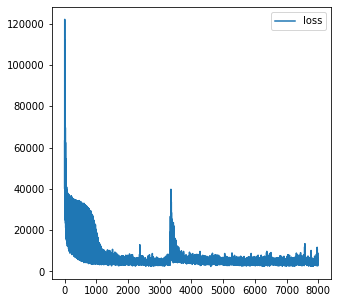

In [ ]:
# Train model
max_iter = 2000
num_samples = 50
anneal_iter = 10000
annealing = False

loss_hist = []

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    for target_idx, (target, rot_mat) in enumerate(zip(img_list[0:count], rot_mats[0:count])):
        optimizer.zero_grad()
        if annealing:
            loss = model.reverse_kld(num_samples, beta=np.min([1., 0.01 + it / anneal_iter]))
        else:
            loss = model.reverse_kld(num_samples, target_idx=target_idx, target=target, rot_mat=rot_mat)
        loss.backward()
        optimizer.step()
        
        loss_hist.append(loss.to('cpu').data.numpy())
        if it % (max_iter/10) == 0:
            print(loss_hist[-1])

plt.figure(figsize=(5, 5))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

In [ ]:
idx = 0
print(pos_list[idx])

tensor([[ 0.0032,  0.0226, -0.0091],
        [ 0.0994,  0.0068, -0.0361],
        [-0.0570, -0.0519, -0.0417]])


tensor([[ 0.0265,  0.0018, -0.0769],
        [ 0.1018,  0.0157,  0.0484],
        [-0.0585, -0.0474, -0.0652]], grad_fn=<DivBackward0>)
tensor(113.6839)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


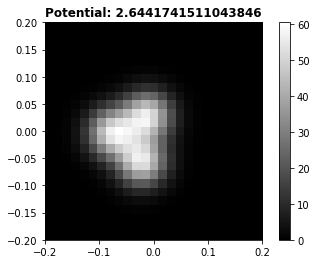

tensor([[ 0.0745,  0.0362,  0.0376],
        [-0.0507,  0.0147, -0.1459],
        [ 0.0945, -0.0668,  0.0546]], grad_fn=<DivBackward0>)
tensor(128.0449)


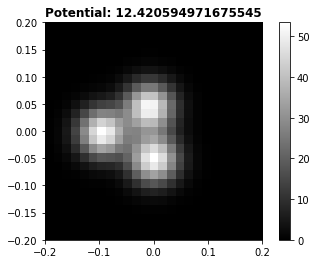

tensor([[ 0.0251,  0.0097, -0.0860],
        [ 0.1074,  0.0192,  0.0575],
        [-0.0663, -0.0481, -0.0673]], grad_fn=<DivBackward0>)
tensor(94.8533)


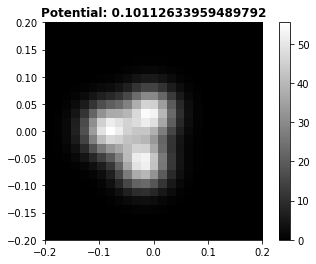

tensor([[ 0.0739,  0.0313,  0.0400],
        [-0.0613,  0.0299, -0.1314],
        [ 0.0910, -0.0726,  0.0600]], grad_fn=<DivBackward0>)
tensor(90.3931)


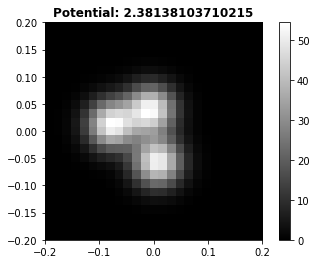

tensor([[ 0.0864,  0.0200,  0.0333],
        [-0.0604,  0.0396, -0.1083],
        [ 0.1144, -0.0821,  0.0494]], grad_fn=<DivBackward0>)
tensor(131.3410)


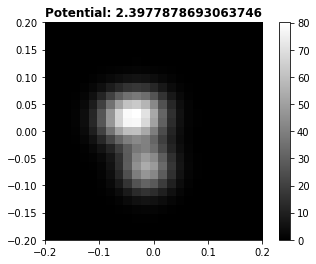

tensor([[ 0.0813,  0.0014,  0.0336],
        [-0.0524,  0.0493, -0.1217],
        [ 0.1153, -0.0711,  0.0578]], grad_fn=<DivBackward0>)
tensor(92.7601)


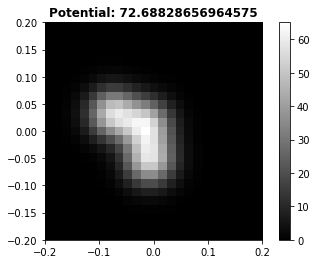

tensor([[ 0.0219,  0.0132, -0.0827],
        [ 0.0987,  0.0090,  0.0460],
        [-0.0589, -0.0412, -0.0526]], grad_fn=<DivBackward0>)
tensor(64.7859)


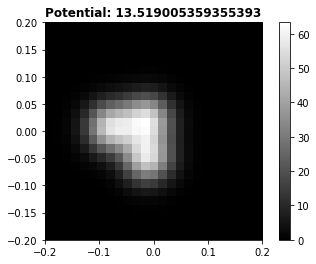

tensor([[ 0.0403,  0.0016,  0.0030],
        [-0.0599,  0.0270, -0.1027],
        [ 0.1250, -0.1033,  0.0516]], grad_fn=<DivBackward0>)
tensor(151.9115)


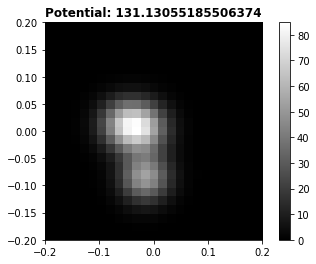

tensor([[ 0.0840,  0.0147,  0.0347],
        [-0.0511,  0.0248, -0.1333],
        [ 0.1065, -0.0779,  0.0521]], grad_fn=<DivBackward0>)
tensor(46.5777)


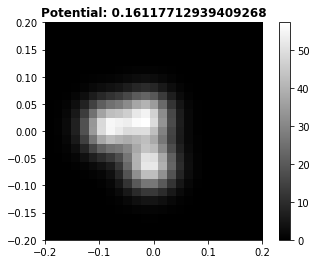

tensor([[ 0.0861,  0.0267,  0.0242],
        [-0.0615,  0.0207, -0.1542],
        [ 0.1086, -0.0559,  0.0450]], grad_fn=<DivBackward0>)
tensor(108.7135)


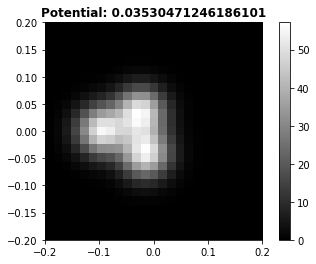

In [ ]:
molecules, _ = model.sample(num_samples=10, idx=idx)

for molecule in molecules:
    simulation.context.setPositions(molecule.reshape(3,3).data.cpu().numpy()/100)
    state = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)

    print((molecule.reshape(3,3)/100))

    img = torch_createblobs(molecule.reshape(3,3)/100, rot_mat=rot_mats[idx]).data
    c = plt.imshow(img.cpu(), cmap ='gray', vmin = 0, vmax = np.abs(img.cpu()).max(),\
                            extent = [-Q,Q,-Q,Q], interpolation = 'nearest', origin = 'lower')
    plt.colorbar(c)

    print(torch.norm(torch.tensor(img) - img_list[idx]))
    plt.title(f'Potential: {state.getPotentialEnergy()._value}', fontweight = "bold")
    plt.show()